## Download and Load the Dataset:

• Access and download the dataset from the provided [link](https://data.mendeley.com/datasets/8h3s6jkyff/1)

• Loadthe images and annotations into your Python environment using TensorFlow
 or PyTorch.

In [1]:
import os
import numpy as np
import pandas as pd
from torchvision.io import read_image
import torch
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import xml.etree.ElementTree as ET
from PIL import Image
from torchvision import transforms
from torchsummary import summary

import torch._dynamo
torch._dynamo.config.suppress_errors = True

In [2]:
class TomatoDataset(Dataset):
    def __init__(self, img_dir, annotations_dir, max_objects=30, transform=None):
        self.img_dir = img_dir
        self.annotations_dir = annotations_dir
        self.max_objects = max_objects
        self.transform = transform

    def __len__(self):
        # Assuming image and annotation files match in number and naming convention
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        # Construct file paths for image and annotation
        annot_file_path = os.path.join(self.annotations_dir, f'{idx:04}.xml')
        img_file_path = os.path.join(self.img_dir, f'{idx:04}.jpg')

        # Load and parse the XML annotation file
        tree = ET.parse(annot_file_path)
        root = tree.getroot()
        boxes = []
        orig_width = int(root.find('./size/width').text)
        orig_height = int(root.find('./size/height').text)

        for obj in root.findall('object'):
            xmin = round(float(obj.find('bndbox/xmin').text))
            ymin = round(float(obj.find('bndbox/ymin').text))
            xmax = round(float(obj.find('bndbox/xmax').text))
            ymax = round(float(obj.find('bndbox/ymax').text))
            boxes.append([xmin, ymin, xmax, ymax])

        # Resize and scale bounding boxes based on new image size
        scale_x, scale_y = 224 / orig_width, 224 / orig_height
        scaled_boxes = []
        for box in boxes[:self.max_objects]:  # Limit to max_objects
            x_min = box[0] * scale_x
            y_min = box[1] * scale_y
            x_max = box[2] * scale_x
            y_max = box[3] * scale_y
            scaled_boxes.append([x_min, y_min, x_max, y_max])

        # Pad or crop boxes to match max_objects
        padded_boxes = np.zeros((self.max_objects, 4))
        scaled_boxes = np.array(scaled_boxes[:self.max_objects])
        padded_boxes[:scaled_boxes.shape[0]] = scaled_boxes

        # Convert boxes to tensor
        boxes_tensor = torch.tensor(padded_boxes, dtype=torch.float32)

        # Load and transform image
        img = Image.open(img_file_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, boxes_tensor

• Resize all images to a uniform size (e.g., 224x224 pixels).

• Normalize pixel values to the range [0, 1].

• Apply data augmentation techniques if necessary (e.g., rotation, flipping).

In [3]:
# Define transformations
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
])

In [4]:
dataset = TomatoDataset(annotations_dir=r'TomatoPlantfactoryDataset\TomatoPlantfactoryDataset\TomatoPlantfactoryDataset\Annotations',
                       img_dir=r'TomatoPlantfactoryDataset\TomatoPlantfactoryDataset\TomatoPlantfactoryDataset\Images', transform=data_transform)

In [5]:
train_size = int(0.8 * len(dataset))
val_size = int(0.05 * len(dataset))
test_size = len(dataset) - train_size - val_size

dataset.__len__(), train_size, val_size, test_size

(520, 416, 26, 78)

In [6]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_loader.__len__(), val_loader.__len__(), test_loader.__len__()

(13, 1, 3)

## Design the CNN Architecture:

• Construct a CNN suitable for object detection and counting.

• Define each layer with parameters such as the number of filters, kernel size, activation functions, and pooling layers.

• Example Architecture:

    – Conv Layer 1: 32 filters, 3x3 kernel, ReLU activation

    – MaxPooling Layer 1: 2x2 pool size

    – Conv Layer 2: 64 filters, 3x3 kernel, ReLU activation

    – MaxPooling Layer 2: 2x2 pool size
    
    – Flatten Layer

    – Dense Layer: 128 neurons, ReLU activation

    – Output Layer: 1 neuron (for count), linear activation

In [7]:
import torch.nn as nn
import torch.optim as optim

class TomatoCounterCNN(nn.Module):
    def __init__(self):
        super(TomatoCounterCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 56 * 56, 128)  # Adjust dimensions based on output size of last pooling layer
        self.fc2 = nn.Linear(128, 1)  # Output layer for counting

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # No activation here for regression output
        return x


## Compile the Model

• Select Mean Squared Error (MSE) as the loss function.

• Choose the Adam optimizer with a learning rate of 0.001.

• Define Mean Absolute Error (MAE) as a metric to monitor.

In [8]:
model = TomatoCounterCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
print(model)

TomatoCounterCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


## Train the CNN

• Split the dataset into training (80%) and testing (20%) sets.

• Train the model for 20 epochs with a batch size of 32.

• Include validation to monitor performance on unseen data.

In [10]:
def train_model(model, train_loader, val_loader, epochs=30, patience=5):
    best_val_mse = float('inf')
    best_model = None
    train_mse_list, val_mse_list = [], []
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for images, boxes in tqdm(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            targets = torch.tensor([len(box[box[:, 0] > 0]) for box in boxes], dtype=torch.float32).unsqueeze(1)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_mse = train_loss / len(train_loader)
        train_mse_list.append(train_mse)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, boxes in val_loader:
                outputs = model(images)
                targets = torch.tensor([len(box[box[:, 0] > 0]) for box in boxes], dtype=torch.float32).unsqueeze(1)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_mse = val_loss / len(val_loader)
        val_mse_list.append(val_mse)

        print(f"Epoch [{epoch+1}/{epochs}], Train MSE: {train_mse:.4f}, Val MSE: {val_mse:.4f}")

        # Early Stopping Check
        if val_mse < best_val_mse:
            best_val_mse = val_mse
            best_model = model.state_dict()  # Save the best model
            patience_counter = 0  # Reset the patience counter
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Load the best model weights
    model.load_state_dict(best_model)
    return model, train_mse_list, val_mse_list

In [11]:
# Run training
model, train_mse_list, val_mse_lis = train_model(model, train_loader, val_loader, epochs=20, patience=5)

100%|██████████| 13/13 [01:19<00:00,  6.08s/it]


Epoch [1/20], Train MSE: 81.8776, Val MSE: 44.2093


100%|██████████| 13/13 [01:24<00:00,  6.54s/it]


Epoch [2/20], Train MSE: 56.5684, Val MSE: 56.8067


100%|██████████| 13/13 [01:25<00:00,  6.57s/it]


Epoch [3/20], Train MSE: 47.5062, Val MSE: 43.5362


100%|██████████| 13/13 [01:21<00:00,  6.23s/it]


Epoch [4/20], Train MSE: 45.6808, Val MSE: 46.6329


100%|██████████| 13/13 [01:25<00:00,  6.60s/it]


Epoch [5/20], Train MSE: 41.5310, Val MSE: 38.1256


100%|██████████| 13/13 [01:23<00:00,  6.43s/it]


Epoch [6/20], Train MSE: 44.2850, Val MSE: 40.9921


100%|██████████| 13/13 [01:25<00:00,  6.54s/it]


Epoch [7/20], Train MSE: 38.2380, Val MSE: 43.9936


100%|██████████| 13/13 [01:18<00:00,  6.04s/it]


Epoch [8/20], Train MSE: 35.3608, Val MSE: 46.1049


100%|██████████| 13/13 [01:17<00:00,  5.96s/it]


Epoch [9/20], Train MSE: 32.4261, Val MSE: 40.4653


100%|██████████| 13/13 [01:17<00:00,  6.00s/it]


Epoch [10/20], Train MSE: 34.6939, Val MSE: 45.6393
Early stopping at epoch 10


## Evaluate the Model

• Assess performance on the testing set using MAE and Root Mean Squared Error (RMSE).

• Create visualizations such as loss curves and scatter plots comparing predicted and actual counts.

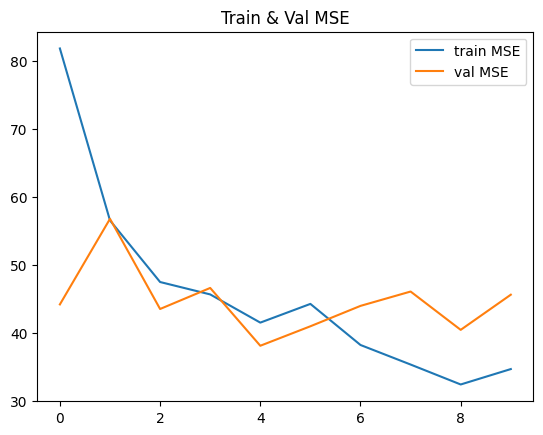

In [12]:
fig, ax = plt.subplots()
ax.plot(train_mse_list)
ax.plot(val_mse_lis)
ax.set_title('Train & Val MSE')
ax.legend(['train MSE', 'val MSE'])
plt.show()

In [13]:
all_true_test_labels = []
all_pred_test_labels = []

for test_image, test_label in test_loader:
    true_label = [int(label.count_nonzero()) for label in torch.sum(test_label, (2))]
    pred_label = [int(label) for label in model(test_image)]
    all_true_test_labels.extend(true_label)
    all_pred_test_labels.extend(pred_label)

print(all_true_test_labels)
print(all_pred_test_labels)

[30, 18, 7, 30, 9, 18, 16, 8, 26, 19, 21, 7, 21, 22, 27, 22, 30, 23, 30, 17, 16, 30, 5, 12, 13, 5, 8, 17, 10, 11, 15, 11, 5, 17, 9, 29, 6, 8, 8, 17, 10, 13, 19, 13, 8, 22, 13, 21, 12, 14, 10, 10, 8, 21, 17, 11, 8, 20, 10, 14, 30, 10, 30, 20, 30, 13, 22, 7, 18, 15, 15, 30, 30, 19, 22, 19, 13, 16]
[13, 11, 10, 19, 14, 15, 10, 9, 9, 11, 12, 6, 8, 13, 12, 12, 15, 12, 11, 12, 10, 15, 11, 10, 11, 14, 7, 12, 8, 9, 7, 9, 12, 8, 6, 14, 6, 8, 9, 14, 7, 19, 10, 8, 7, 12, 9, 18, 11, 12, 13, 9, 13, 14, 10, 10, 5, 10, 10, 17, 12, 10, 9, 16, 11, 8, 12, 12, 11, 9, 11, 12, 19, 10, 11, 11, 10, 11]


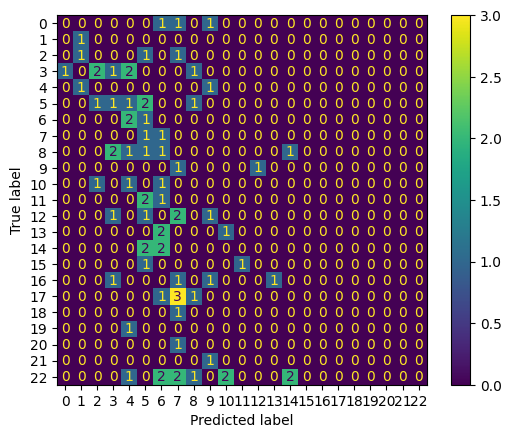

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true=all_true_test_labels, y_pred=all_pred_test_labels)
disp = ConfusionMatrixDisplay(cm)
disp.plot()